In [ ]:
import numpy as np 
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit 
import matplotlib.colors as colors
from mpl_toolkits.mplot3d import Axes3D


In [110]:
def sin_func(t, A, f, phi):
    return A * np.sin(2 * np.pi * f * t + phi)


def dec_sin_func(t, g, f, phi, A=1.0):
    return A * np.exp(-1* g * t) * np.sin(2 * np.pi * f * t + phi)


def square_sin_error_weighted(time, data, data_sig, freqs, phis, man_phi, want_2d=False):
    freq_errors=[]
    best_phis = []
    for f in freqs:
        phi_errors=[]
        for phi in phis: 
            phi_errors.append(0.5*np.sum(1/(data_sig**2) * (data - np.sin(2*np.pi*f*time + phi - man_phi))**2))
        if want_2d:
            freq_errors.append(phi_errors)
        else:
            freq_errors.append(np.min(phi_errors))
            best_phis.append(phis[np.argmin(phi_errors)])
            
    return np.array(freq_errors), np.array(best_phis)


def ls_laplace(time, data, data_std, decays, freqs, phis, collapse_phi=True, A=1.0):
    "for collapsing phi, returns 2D array of decay vs freq errors"
    decay_errors=[]
    for g in decays:
        freq_errors = []
        for f in freqs: 
            phi_errors=[]
            for phi in phis:
                model = dec_sin_func(time, g, f, phi, A=A)
                sq_err = 0.5*np.sum(1/(data_std**2) * (data - model)**2)
                phi_errors.append(sq_err)
            if collapse_phi:
                freq_errors.append(np.min(phi_errors))
            else:
                freq_errors.append(phi_errors)
        decay_errors.append(freq_errors)
    return np.array(decay_errors)  


class Fringe:
    def __init__(self, g, f_0, phi, A=1.0):
        self.f_0 = f_0
        self.g = g
        self.A = A
        self.phi = phi

    def eval_pure(self, t):
        return self.A * np.exp(-1 * self.g * t) * np.sin(2 * np.pi * self.f_0 * t + self.phi)

    def add_noise(self, data, noise_level):
        noise = np.random.normal(0, noise_level, size=data.shape)
        return data + noise
    
    def eval_noisy(self, t):
        data_pure = self.eval_pure(t)
        data1 = self.add_noise(np.array(data_pure), noise_level=0.2)
        data2 = self.add_noise(np.array(data_pure), noise_level=0.2)
        data3 = self.add_noise(np.array(data_pure), noise_level=0.3)
        data_avg = np.mean([data1, data2, data3], axis=0)
        data_std = np.std([data1, data2, data3], axis=0)

        return data_avg, data_std


def gen_sample(fringe, t_hold_center, f_samp, no_samp, want_noise=True):
    if no_samp % 2 == 0:
        raise ValueError("no_samp must be odd")
    dt = 1 / f_samp
    half_span = (no_samp - 1) // 2 * dt
    t_range = np.linspace(t_hold_center - half_span, 
                          t_hold_center + half_span, 
                          no_samp)
    if want_noise:
        avg, std = fringe.eval_noisy(t_range)
    else:
        avg = fringe.eval_pure(t_range)
        std = np.ones_like(avg)*0.01
    # print(t_range)
    return t_range, avg, std


def gen_sample_by_width_and_no(fringe, t_hold_center, width, no_samp):
    t_range = np.linspace(t_hold_center - width / 2, t_hold_center + width / 2, no_samp)
    r_samp = 1/(t_range[1] - t_range[0])
    if r_samp < 2 * fringe.f_0:
        print(f"Warning: Sampling rate {r_samp} is less than twice the signal frequency {fringe.f_0}")
    avg, std = fringe.eval_noisy(t_range)
    return t_range, avg, std

def multi_sample_harm_elim(fringe, no_fringes, start_t_center, end_t_center, sample_freq, samp_no = 11):
    no_node_fringes = no_fringes - 2    
    tc_sep = end_t_center - start_t_center
    t_centers = [start_t_center]

    for i in range(1, no_node_fringes + 1):
        t_centers.append(start_t_center + tc_sep * 1/(2**i))

    t_centers.append(end_t_center)

    t_centers = np.sort(np.array(t_centers))

    print(f'first t center: {start_t_center*1e3} ms')
    print(f'fringe centers: {(t_centers-start_t_center)*1e3}')
    print(f'Fractional separations:{(t_centers-start_t_center)/tc_sep}')

    all_times = []
    all_avgs = []
    all_stds = []

    for i in range(no_fringes):
        t, avg, std = gen_sample(fringe, t_hold_center=t_centers[i], f_samp=sample_freq, no_samp=samp_no, want_noise=True)
        all_times.append(t)
        all_avgs.append(avg)
        all_stds.append(std)

    return np.array(all_times), np.array(all_avgs), np.array(all_stds)


In [19]:
# Constants 

TRU_FREQ = 25e3 
TRU_TAU = 1/TRU_FREQ
# TRU_G = 1/(1/TRU_FREQ * 1000)
TRU_G = 1/(1000*TRU_TAU)
F_SAMP = np.pi * TRU_FREQ * 1.5  # use irrational number to avoid patterned fringe sampling

if F_SAMP <= 2 * TRU_FREQ:
    raise ValueError("Sampling frequency must be greater than twice the true frequency, as per Nyquist Criterion")

print(f'Sample freq = {F_SAMP/TRU_FREQ} times the true frequency')

TRU_FRINGE = Fringe(g=TRU_G, f_0=TRU_FREQ, phi=0)

Sample freq = 4.712388980384689 times the true frequency


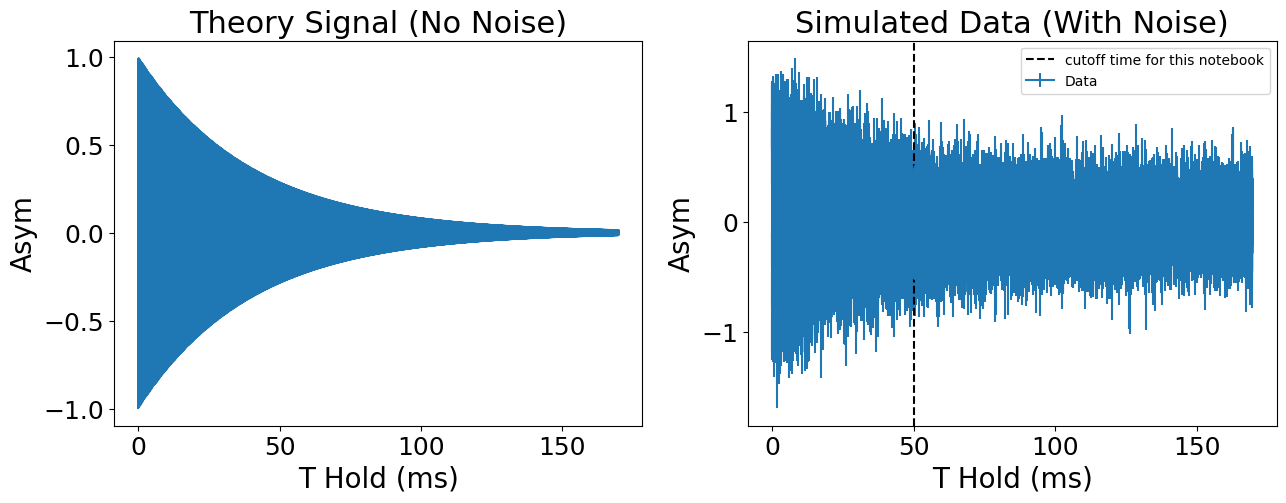

In [20]:
s_no = 20001

t0, avg0, std0 = gen_sample(TRU_FRINGE, t_hold_center=(1/F_SAMP)*s_no/2, f_samp=F_SAMP, no_samp=s_no, want_noise=False)
fig, ax = plt.subplots(1, 2, figsize=(15, 5))

ax[0].plot(t0*1e3, avg0, label='Average')
ax[0].set_xlabel('T Hold (ms)')
ax[0].set_ylabel('Asym')
ax[0].set_title('Theory Signal (No Noise)')

t0, avg0, std0 = gen_sample(TRU_FRINGE, t_hold_center=(1/F_SAMP)*s_no/2, f_samp=F_SAMP, no_samp=s_no, want_noise=True)

ax[1].errorbar(t0*1e3, avg0, yerr=std0, label='Data')
ax[1].set_xlabel('T Hold (ms)')
ax[1].set_ylabel('Asym')
ax[1].set_title('Simulated Data (With Noise)')
ax[1].axvline(x=50, color='k', linestyle='--', label='cutoff time for this notebook')
ax[1].legend()

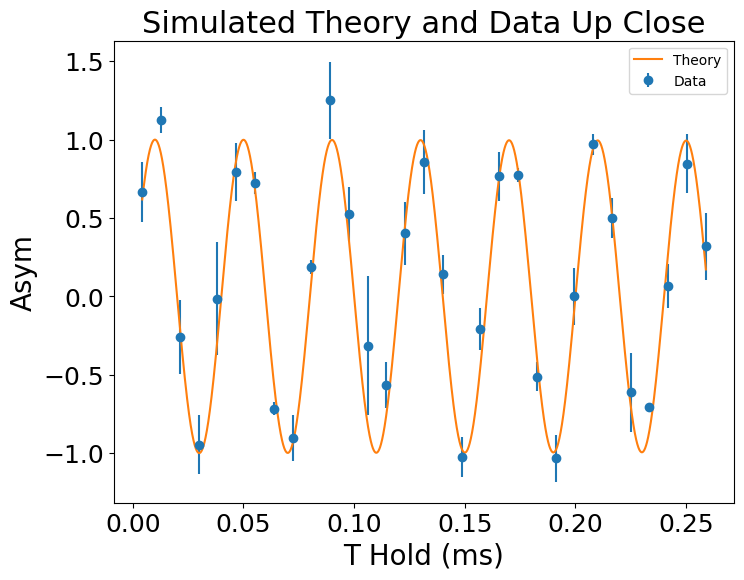

In [21]:
s_no = 31

t0, avg0, std0 = gen_sample(TRU_FRINGE, t_hold_center=(1/F_SAMP)*s_no/2, f_samp=F_SAMP, no_samp=s_no, want_noise=True)

plt.errorbar(t0*1e3, avg0, yerr=std0, fmt = 'o', label='Data')

t0, avg0, std0 = gen_sample(TRU_FRINGE, t_hold_center=(1/F_SAMP)*s_no/2, f_samp=F_SAMP*100, no_samp=(s_no-1)*100+1, want_noise=False)

plt.plot(t0*1e3, avg0, label='Theory')

plt.xlabel('T Hold (ms)')
plt.ylabel('Asym')
plt.title('Simulated Theory and Data Up Close')
plt.legend()

In [23]:
all_times, all_avgs, all_stds = multi_sample_harm_elim(TRU_FRINGE, no_fringes=7, start_t_center=TRU_TAU*10, end_t_center=50e-3, sample_freq=F_SAMP, samp_no=11)

first t center: 0.4 ms
fringe centers: [ 0.    1.55  3.1   6.2  12.4  24.8  49.6 ]
Fractional separations:[0.      0.03125 0.0625  0.125   0.25    0.5     1.     ]


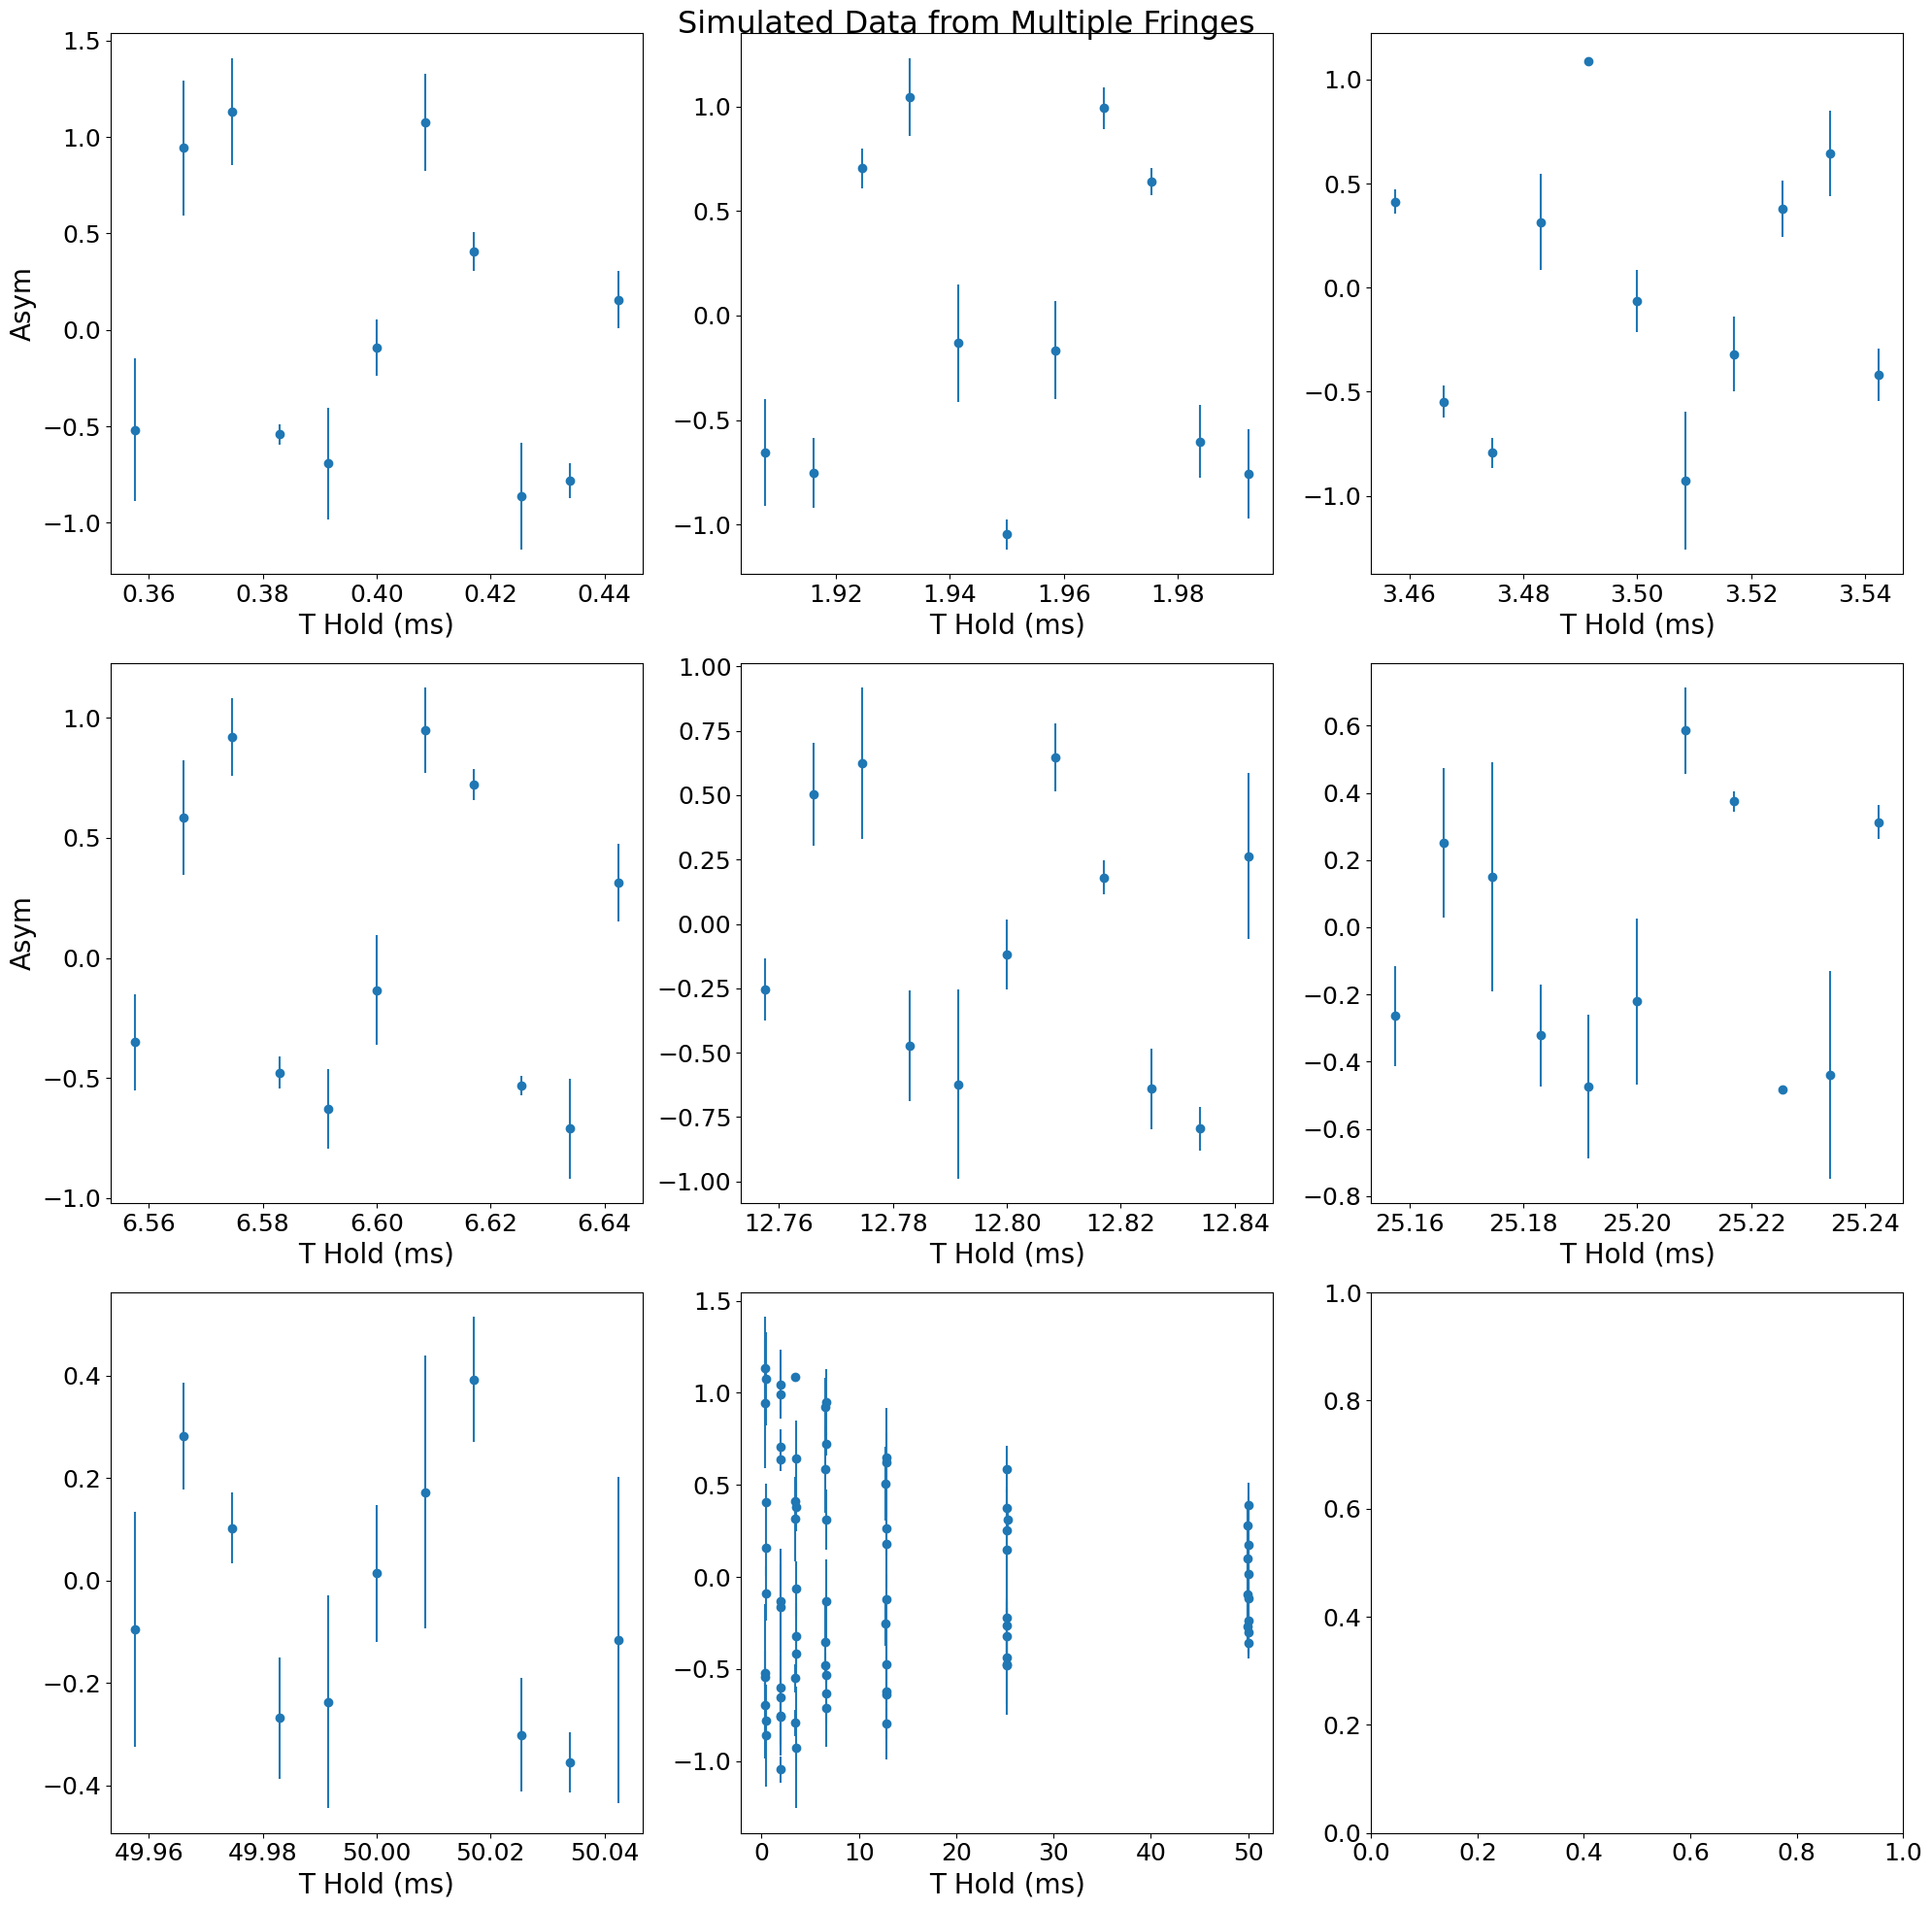

In [47]:
fig, ax = plt.subplots(3, 3, figsize=(20, 20))
for i in range(8):
    if i == 7: 
        ax[2,1].errorbar(np.concatenate(all_times)*1e3, np.concatenate(all_avgs), yerr=np.concatenate(all_stds), fmt='o')
        ax[2,1].set_xlabel('T Hold (ms)')
        # ax[2,1].set_ylabel('Asym')
        break
    r = i // 3
    c = i % 3
    ax[r, c].errorbar(all_times[i]*1e3, all_avgs[i], yerr=all_stds[i], fmt='o', label=f'Data {i+1}')
    ax[r, c].set_xlabel('T Hold (ms)')
    # ax[r, c].set_ylabel('Asym')
    # if i == 4:
    #     ax[1, 2].scatter(np.concatenate(all_times)*1e3, np.concatenate(all_avgs))
    #     ax[1, 2].set_xlabel('T Hold (ms)')
    #     # ax[1, 2].set_ylabel('Asym')
ax[0,0].set_ylabel('Asym')
ax[1,0].set_ylabel('Asym')
fig.suptitle('Simulated Data from Multiple Fringes', fontsize=23)
fig.tight_layout()

In [88]:
def fit_amplitude(time, data, data_std, init_params):
    'expects init params (A, f, phi)'
    popt, pcov = curve_fit(sin_func, time, data, sigma=data_std, p0=init_params, absolute_sigma=True)
    perr = np.sqrt(np.diag(pcov))
    print(f'Fitted parameters: A={popt[0]} +/- {perr[0]}, f={popt[1]} +/- {perr[1]}, phi={popt[2]} +/- {perr[2]}')
    return popt[0], perr[0]


def get_all_amps(all_times, all_avgs, all_stds, A_fit_p0):
    all_amps = []
    all_amp_errs = []

    for i in range(np.shape(all_avgs)[0]):
        Amp, A_err = fit_amplitude(all_times[i], all_avgs[i], all_stds[i], init_params=A_fit_p0)
        all_amps.append(Amp)
        all_amp_errs.append(A_err)

    center_times = []

    for fringe_time in all_times:
        center_times.append(fringe_time[len(fringe_time)//2])

    return np.array(center_times), np.array(all_amps), np.array(all_amp_errs)

def exp_fit_func(t, A, g):
    return A * np.exp(-1 * g * t)

def fit_contrast_decay(all_times, all_avgs, all_stds, decay_fit_p0, A_fit_p0, want_amp_data=False):
    
    center_times, all_amps, all_amp_errs = get_all_amps(all_times, all_avgs, all_stds, A_fit_p0=A_fit_p0)

    popt, pcov = curve_fit(exp_fit_func, center_times, all_amps, sigma=all_amp_errs, p0=decay_fit_p0, absolute_sigma=True)
    perr = np.sqrt(np.diag(pcov))
    print(f'Fitted decay parameters: A_0={popt[0]} +/- {perr[0]}, g={popt[1]} +/- {perr[1]}')
    if want_amp_data:
        return center_times, all_amps, all_amp_errs, popt, perr
    else:
        return popt, perr


Fitted parameters: A=0.9890398417655321 +/- 0.07846280453136174, f=24613.09471265897 +/- 405.8413642582443, phi=1.0050943799270764 +/- 1.0262863308591617
Fitted parameters: A=1.058155833149689 +/- 0.04771303277476059, f=25437.890968825686 +/- 356.5677900036699, phi=-5.362026981015366 +/- 4.383407948393968
Fitted parameters: A=1.0700319404748895 +/- 0.01845816801995016, f=25047.043772481644 +/- 213.46034229567178, phi=-1.130050434732813 +/- 4.670423324145527
Fitted parameters: A=0.9913166341806743 +/- 0.05095528446414712, f=24190.985614654415 +/- 262.33524051593156, phi=33.40595398641423 +/- 10.896342306186064
Fitted parameters: A=0.770081773721868 +/- 0.07050235334152323, f=24965.662589717096 +/- 421.0680336546395, phi=2.817942068353617 +/- 33.87342088807227
Fitted parameters: A=0.665496158806506 +/- 0.022576975953269497, f=25605.125789979462 +/- 407.7036105901637, phi=-95.9575328755225 +/- 64.60595305225388
Fitted parameters: A=0.3550426110695479 +/- 0.04532768103973993, f=22577.09350

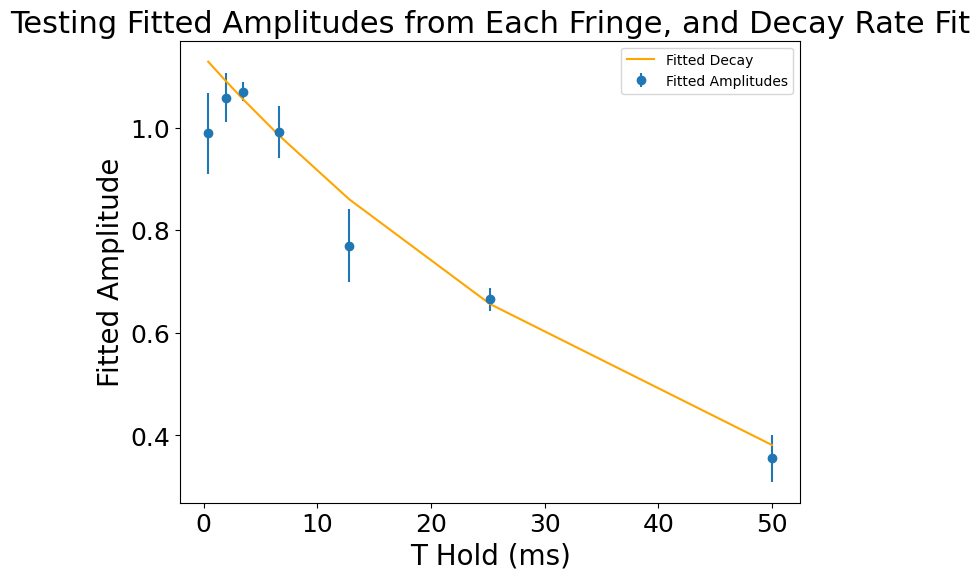

In [89]:
center_times, all_amps, all_amp_errs, popt_test, perr_test = fit_contrast_decay(all_times, all_avgs, all_stds, decay_fit_p0=(1, TRU_G), A_fit_p0=(1.0, TRU_FREQ, 0), want_amp_data=True)

plt.errorbar(center_times*1e3, all_amps, yerr=all_amp_errs, fmt='o', label='Fitted Amplitudes' )
plt.plot(center_times*1e3, exp_fit_func(center_times, *popt_test), label='Fitted Decay', color='orange')
plt.xlabel('T Hold (ms)')
plt.ylabel('Fitted Amplitude')
plt.title('Testing Fitted Amplitudes from Each Fringe, and Decay Rate Fit')
plt.legend()

print(f'True decay rate: {TRU_G}, Fitted decay rate: {popt_test[1]} +/- {perr_test[1]}')

In [90]:
FT_F_RANGE = np.linspace(TRU_FREQ*0.8, TRU_FREQ*1.2, 10000)
PHI_RANGE = np.linspace(-np.pi, np.pi, 100)
f_phi_mesh = np.meshgrid(PHI_RANGE, FT_F_RANGE)


In [91]:
last_ft, last_fa, last_fs = all_times[-1], all_avgs[-1], all_stds[-1]
error_ls, _ = square_sin_error_weighted(last_ft, last_fa, last_fs, freqs=FT_F_RANGE, phis=PHI_RANGE, man_phi=0, want_2d=True)
error_ls_1d, _ = square_sin_error_weighted(last_ft, last_fa, last_fs, freqs=FT_F_RANGE, phis=PHI_RANGE, man_phi=0, want_2d=False)   





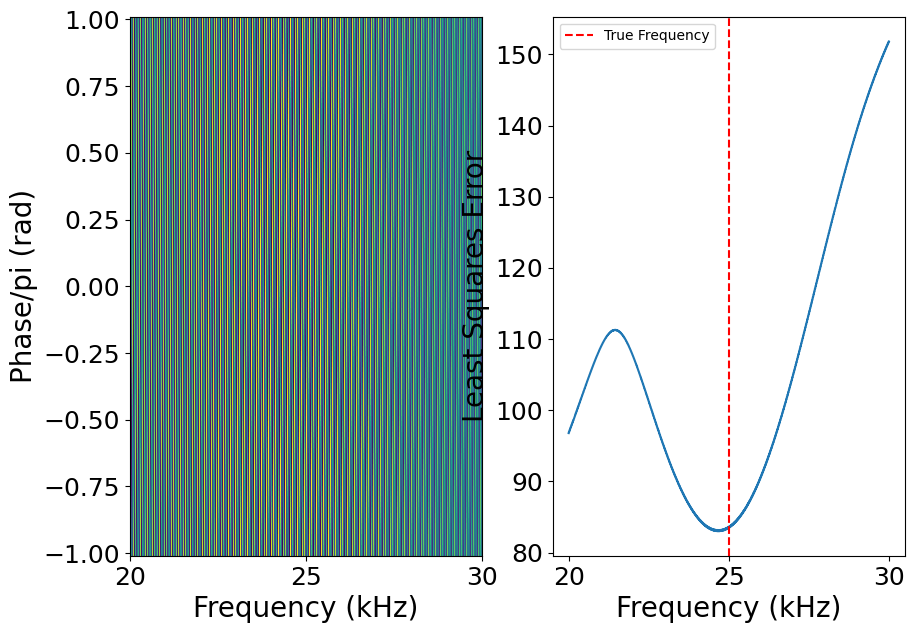

In [92]:
fig,ax = plt.subplots(1, 2, figsize=(10, 7))
ax[0].pcolormesh(f_phi_mesh[1]*1e-3, f_phi_mesh[0]/np.pi, error_ls, shading='auto')
ax[0].set_xlabel('Frequency (kHz)')
ax[0].set_ylabel('Phase/pi (rad)')

ax[1].plot(FT_F_RANGE*1e-3, error_ls_1d)
ax[1].set_xlabel('Frequency (kHz)')
ax[1].set_ylabel('Least Squares Error')
ax[1].axvline(x=TRU_FREQ*1e-3, color='r', linestyle='--', label='True Frequency')
ax[1].legend()

In [131]:
DECAY_RANGE = np.linspace(0, TRU_G*1.5, 16)

LT_FREQ_RANGE = np.linspace(20, 30, 10000)*1e3
LT_PHI_RANGE = np.linspace(-np.pi, np.pi, 60)

lt_meshgrid = np.meshgrid(DECAY_RANGE, LT_FREQ_RANGE)


In [132]:
all_times_concat = np.concatenate(all_times)
all_avgs_concat = np.concatenate(all_avgs)
all_stds_concat = np.concatenate(all_stds)

laplace_domain_error = ls_laplace(all_times_concat, all_avgs_concat, all_stds_concat, decays=DECAY_RANGE, freqs=LT_FREQ_RANGE, phis=LT_PHI_RANGE, collapse_phi=True, A=1.0)



In [133]:
print(laplace_domain_error.shape)

(16, 10000)


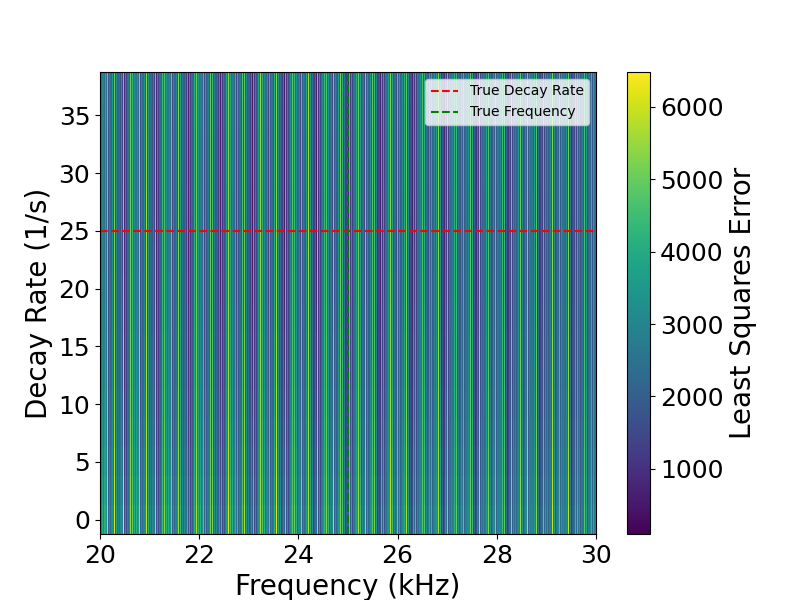

In [135]:
plt.close('all')
plt.pcolormesh(lt_meshgrid[1]*1e-3, lt_meshgrid[0], laplace_domain_error.T, shading='auto')
plt.colorbar(label='Least Squares Error')
plt.axhline(y=TRU_G, color='r', linestyle='--', label='True Decay Rate')
plt.axvline(x=TRU_FREQ*1e-3, color='g', linestyle='--', label='True Frequency')
plt.xlabel('Frequency (kHz)')
plt.ylabel('Decay Rate (1/s)')
plt.legend()

In [139]:
def get_best_decays(decay_range, freq_range, laplace_domain_error):
    best_decays = []
    for i,f in enumerate(freq_range):
        best_decays.append(decay_range[np.argmin(laplace_domain_error[:, i])])
    return np.array(best_decays)

def get_best_freqs(decay_range, freq_range, laplace_domain_error):
    best_freqs = []
    for i,d in enumerate(decay_range):
        best_freqs.append(freq_range[np.argmin(laplace_domain_error[i, :])])
    return np.array(best_freqs)


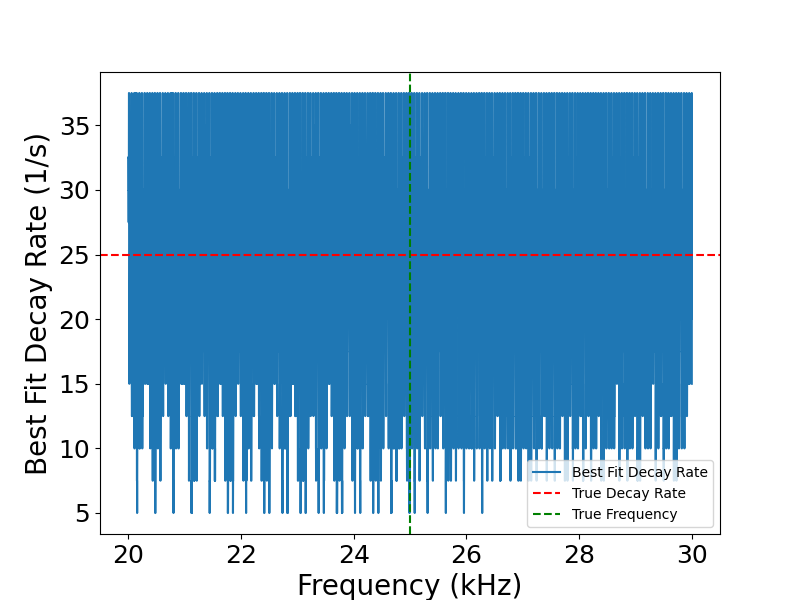

In [138]:
plt.close('all')


best_decays = get_best_decays(DECAY_RANGE, LT_FREQ_RANGE, laplace_domain_error)

plt.plot(LT_FREQ_RANGE*1e-3, best_decays, label='Best Fit Decay Rate')
plt.axhline(y=TRU_G, color='r', linestyle='--', label='True Decay Rate')
plt.axvline(x=TRU_FREQ*1e-3, color='g', linestyle='--', label='True Frequency')
plt.xlabel('Frequency (kHz)')
plt.ylabel('Best Fit Decay Rate (1/s)')
plt.legend()


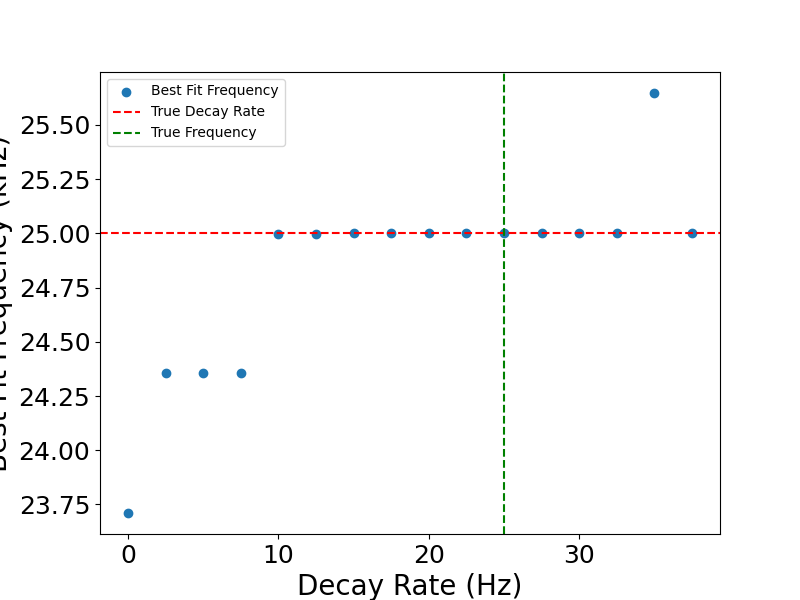

In [146]:
plt.close('all')

best_freqs = get_best_freqs(DECAY_RANGE, LT_FREQ_RANGE, laplace_domain_error)

plt.scatter(DECAY_RANGE, best_freqs*1e-3, label='Best Fit Frequency')
plt.axhline(y=TRU_G, color='r', linestyle='--', label='True Decay Rate')
plt.axvline(x=TRU_FREQ*1e-3, color='g', linestyle='--', label='True Frequency')
plt.ylabel('Best Fit Frequency (kHz)')
plt.xlabel('Decay Rate (Hz)')
plt.legend()

In [147]:
print(np.argmin(np.abs((DECAY_RANGE-TRU_G))))

10


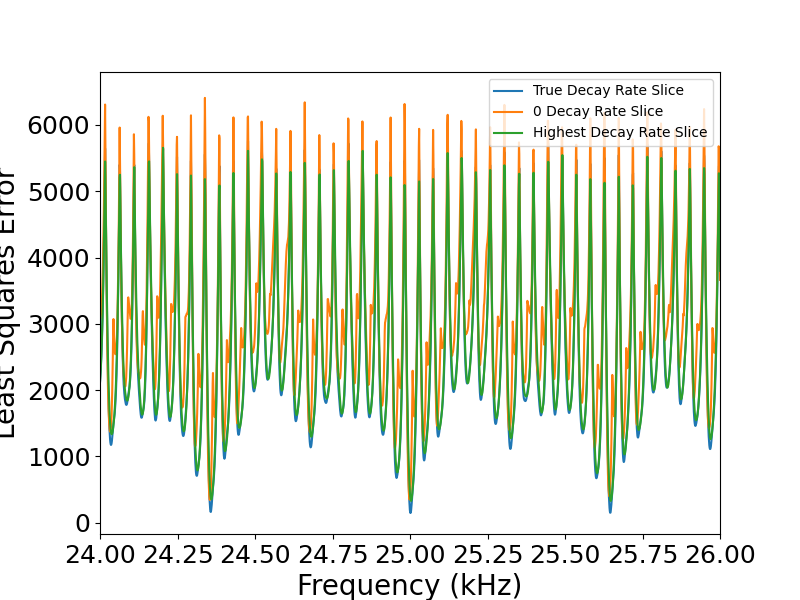

In [159]:
plt.close('all')
plt.plot(LT_FREQ_RANGE*1e-3, laplace_domain_error[10, :], label='True Decay Rate Slice')
plt.plot(LT_FREQ_RANGE*1e-3, laplace_domain_error[0, :], label='0 Decay Rate Slice')
plt.plot(LT_FREQ_RANGE*1e-3, laplace_domain_error[15, :], label='Highest Decay Rate Slice')
plt.xlabel('Frequency (kHz)')
plt.ylabel('Least Squares Error')
plt.xlim(24,26)
plt.legend()

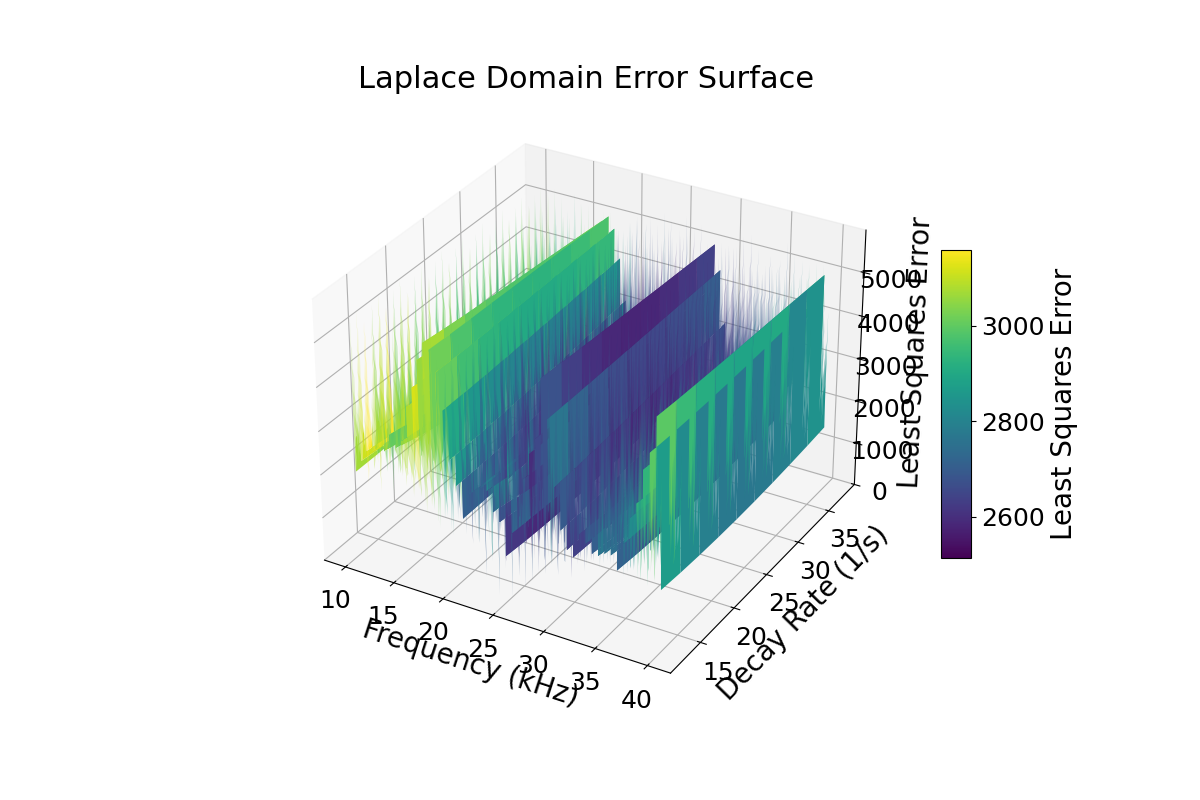

AttributeError: 'QuadMesh' object has no attribute 'do_3d_projection'

In [109]:
%matplotlib widget

plt.close('all')

fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection='3d')

# LT_FREQ_RANGE and DECAY_RANGE must match the shape of laplace_domain_error
X, Y = np.meshgrid(LT_FREQ_RANGE*1e-3, DECAY_RANGE)  # X: freq (kHz), Y: decay

# laplace_domain_error.T to match meshgrid orientation if needed
surf = ax.plot_surface(X, Y, laplace_domain_error.T, cmap='viridis', edgecolor='none')

ax.set_xlabel('Frequency (kHz)')
ax.set_ylabel('Decay Rate (1/s)')
ax.set_zlabel('Least Squares Error')
ax.set_title('Laplace Domain Error Surface')
fig.colorbar(surf, shrink=0.5, aspect=10, label='Least Squares Error')
plt.show()